In [3]:
import json
import random
import uuid
import numpy as np
import time
import requests
import traceback
import math
import ast
import pandas as pd
import seaborn as sns
import pdb
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
tqdm.pandas()

In [5]:
textual_entailment_df = pd.read_json('../data/textual_entailment_df.json')
textual_entailment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409 entries, 0 to 408
Data columns (total 31 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   reference_id                               409 non-null    object 
 1   claim_id                                   409 non-null    object 
 2   final_verbalisation                        409 non-null    object 
 3   sampling_weight                            409 non-null    float64
 4   final_url                                  409 non-null    object 
 5   netloc_agg                                 409 non-null    object 
 6   nlp_sentences                              409 non-null    object 
 7   nlp_sentences_slide_2                      409 non-null    object 
 8   nlp_sentences_scores                       409 non-null    object 
 9   nlp_sentences_slide_2_scores               409 non-null    object 
 10  nlp_sentences_TOP_N       

In [6]:
SCORE_THRESHOLD = 0

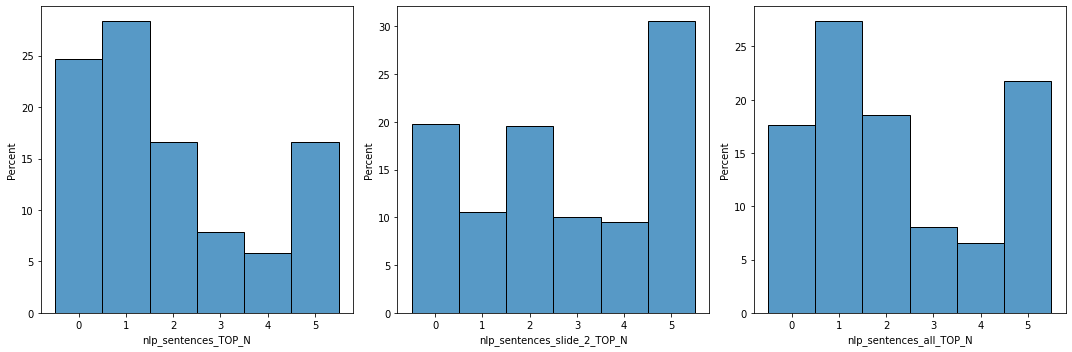

In [7]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

sns.histplot(
    textual_entailment_df.nlp_sentences_TOP_N.apply(lambda x : len([xx for xx in x if xx['score'] > SCORE_THRESHOLD])),
    ax=ax[0], stat='percent', discrete=True
)
sns.histplot(
    textual_entailment_df.nlp_sentences_slide_2_TOP_N.apply(lambda x : len([xx for xx in x if xx['score'] > SCORE_THRESHOLD])),
    ax=ax[1], stat='percent', discrete=True
)
sns.histplot(
    textual_entailment_df.nlp_sentences_all_TOP_N.apply(lambda x : len([xx for xx in x if xx['score'] > SCORE_THRESHOLD])),
    ax=ax[2], stat='percent', discrete=True
)

plt.tight_layout()
plt.show()

# We see the majority of claims (between 65% and 75%) have at least one sentence selected as relevant.
# Let's get the all_TOP_N percentage of non-zeroes per netloc

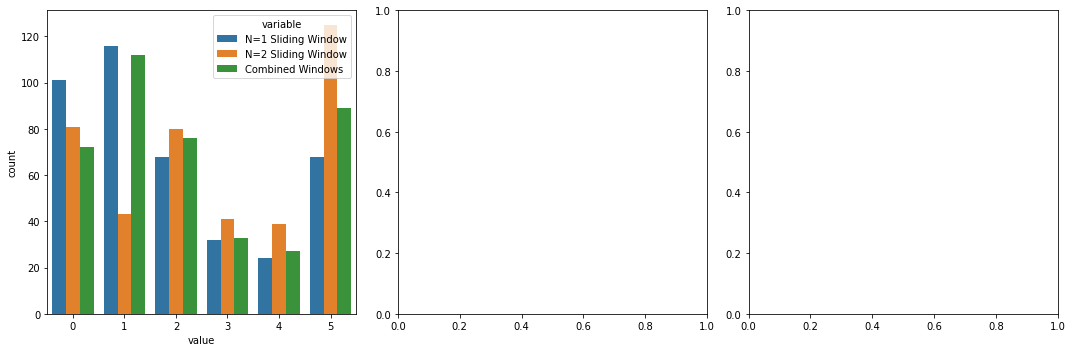

variable            value
Combined Windows    0        0.176039
                    1        0.273839
                    2        0.185819
                    3        0.080685
                    4        0.066015
                    5        0.217604
N=1 Sliding Window  0        0.246944
                    1        0.283619
                    2        0.166259
                    3        0.078240
                    4        0.058680
                    5        0.166259
N=2 Sliding Window  0        0.198044
                    1        0.105134
                    2        0.195599
                    3        0.100244
                    4        0.095355
                    5        0.305623
dtype: float64

In [8]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

df = textual_entailment_df[['nlp_sentences_TOP_N','nlp_sentences_slide_2_TOP_N','nlp_sentences_all_TOP_N']].copy()
df['nlp_sentences_TOP_N_above_thr'] =\
    df.nlp_sentences_TOP_N.apply(lambda x : len([xx for xx in x if xx['score'] > SCORE_THRESHOLD]))
df['nlp_sentences_slide_2_TOP_N_above_thr'] =\
    df.nlp_sentences_slide_2_TOP_N.apply(lambda x : len([xx for xx in x if xx['score'] > SCORE_THRESHOLD]))
df['nlp_sentences_all_TOP_N_above_thr'] =\
    df.nlp_sentences_all_TOP_N.apply(lambda x : len([xx for xx in x if xx['score'] > SCORE_THRESHOLD]))

df = df.drop(['nlp_sentences_TOP_N','nlp_sentences_slide_2_TOP_N','nlp_sentences_all_TOP_N'], axis=1)
df = df.rename({
    'nlp_sentences_TOP_N_above_thr': 'N=1 Sliding Window',
    'nlp_sentences_slide_2_TOP_N_above_thr': 'N=2 Sliding Window',
    'nlp_sentences_all_TOP_N_above_thr': 'Combined Windows'
}, axis=1)
df = df.melt()

sns.countplot(
    x=df.value,
    hue=df.variable,
    #hue_order='',
    ax=ax[0]
)
#sns.histplot(
#    textual_entailment_df.nlp_sentences_slide_2_TOP_N.apply(lambda x : len([xx for xx in x if xx['score'] > SCORE_THRESHOLD])),
#    ax=ax[1], stat='percent', discrete=True
#)
#sns.histplot(
#    textual_entailment_df.nlp_sentences_all_TOP_N.apply(lambda x : len([xx for xx in x if xx['score'] > SCORE_THRESHOLD])),
#    ax=ax[2], stat='percent', discrete=True
#)

plt.tight_layout()
plt.show()

df.groupby('variable').value_counts(normalize=True,sort=False)
# We see the majority of claims (between 65% and 75%) have at least one sentence selected as relevant.
# Let's get the all_TOP_N percentage of non-zeroes per netloc

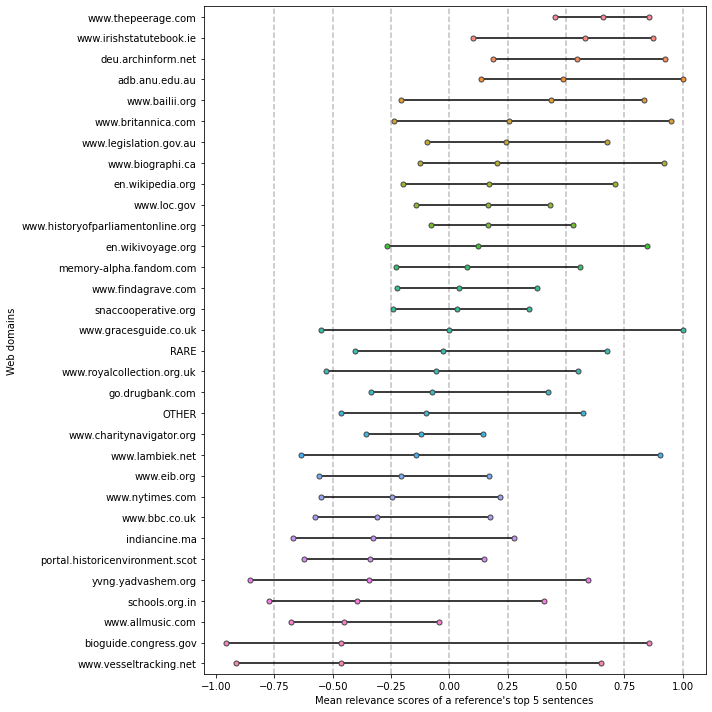

In [9]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

df = textual_entailment_df[['netloc_agg', 'nlp_sentences_all_TOP_N']].copy()

df['nlp_sentences_all_TOP_N_score_mean'] = df.nlp_sentences_all_TOP_N.apply(
    lambda x : np.mean([xx['score'] for xx in x] if len(x) > 0 else 0)
)
df['nlp_sentences_all_TOP_N_score_max'] = df.nlp_sentences_all_TOP_N.apply(
    lambda x : np.max([xx['score'] for xx in x] if len(x) > 0 else 0)
)
df['nlp_sentences_all_TOP_N_score_min'] = df.nlp_sentences_all_TOP_N.apply(
    lambda x : np.min([xx['score'] for xx in x] if len(x) > 0 else 0)
)
df = df.groupby('netloc_agg').mean().reset_index()
df = df.sort_values('nlp_sentences_all_TOP_N_score_mean', ascending=False).reset_index(drop=True)

for i, row in df.iterrows():
    plt.hlines(
        y=i,
        xmin=row['nlp_sentences_all_TOP_N_score_min'],
        xmax=row['nlp_sentences_all_TOP_N_score_max'],
        color='black'
    )

sns.swarmplot(
    data=df,
    x='nlp_sentences_all_TOP_N_score_mean',
    y='netloc_agg',
    order=df.netloc_agg,
    ax=ax,
    linewidth=1
)
sns.swarmplot(
    data=df,
    x='nlp_sentences_all_TOP_N_score_max',
    y='netloc_agg',
    order=df.netloc_agg,
    ax=ax,
    linewidth=1
)
sns.swarmplot(
    data=df,
    x='nlp_sentences_all_TOP_N_score_min',
    y='netloc_agg',
    order=df.netloc_agg,
    ax=ax,
    linewidth=1
)

plt.axvline(x=1.00, c='black', ls='--', alpha=0.25)
plt.axvline(x=0.75, c='black', ls='--', alpha=0.25)
plt.axvline(x=0.50, c='black', ls='--', alpha=0.25)
plt.axvline(x=0.25, c='black', ls='--', alpha=0.25)
plt.axvline(x=0.00, c='black', ls='--', alpha=0.25)
plt.axvline(x=-0.75, c='black', ls='--', alpha=0.25)
plt.axvline(x=-0.50, c='black', ls='--', alpha=0.25)
plt.axvline(x=-0.25, c='black', ls='--', alpha=0.25)

plt.ylabel('Web domains')
plt.xlabel('Mean relevance scores of a reference\'s top 5 sentences')

plt.tight_layout()
plt.show()
# generate a version of this without bad netlocs

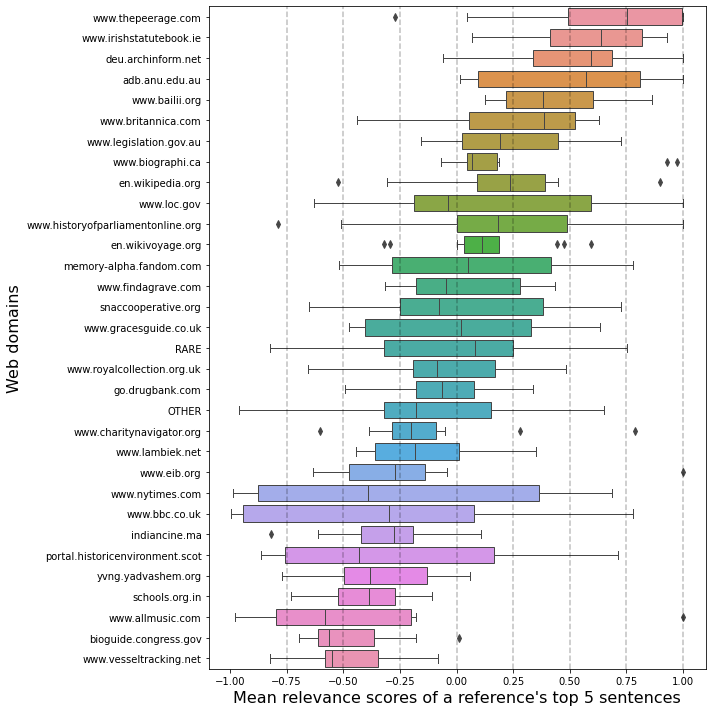

In [10]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

df = textual_entailment_df[['netloc_agg', 'nlp_sentences_all_TOP_N']].copy()

df['nlp_sentences_all_TOP_N_score_mean'] = df.nlp_sentences_all_TOP_N.apply(
    lambda x : np.mean([xx['score'] for xx in x] if len(x) > 0 else 0)
)

sns.boxplot(
    data=df,
    x='nlp_sentences_all_TOP_N_score_mean',
    y='netloc_agg',
    order=df.groupby('netloc_agg').nlp_sentences_all_TOP_N_score_mean.mean().sort_values(ascending=False).index,
    ax=ax,
    linewidth=1
)

plt.axvline(x=1.00, c='black', ls='--', alpha=0.25)
plt.axvline(x=0.75, c='black', ls='--', alpha=0.25)
plt.axvline(x=0.50, c='black', ls='--', alpha=0.25)
plt.axvline(x=0.25, c='black', ls='--', alpha=0.25)
plt.axvline(x=0.00, c='black', ls='--', alpha=0.25)
plt.axvline(x=-0.75, c='black', ls='--', alpha=0.25)
plt.axvline(x=-0.50, c='black', ls='--', alpha=0.25)
plt.axvline(x=-0.25, c='black', ls='--', alpha=0.25)

plt.ylabel('Web domains', size=16)
plt.xlabel('Mean relevance scores of a reference\'s top 5 sentences', size=16)

plt.tight_layout()

# generate a version of this without bad netlocs
plt.savefig('../imgs/relevance_scores_per_web_domain.pdf')
plt.show()

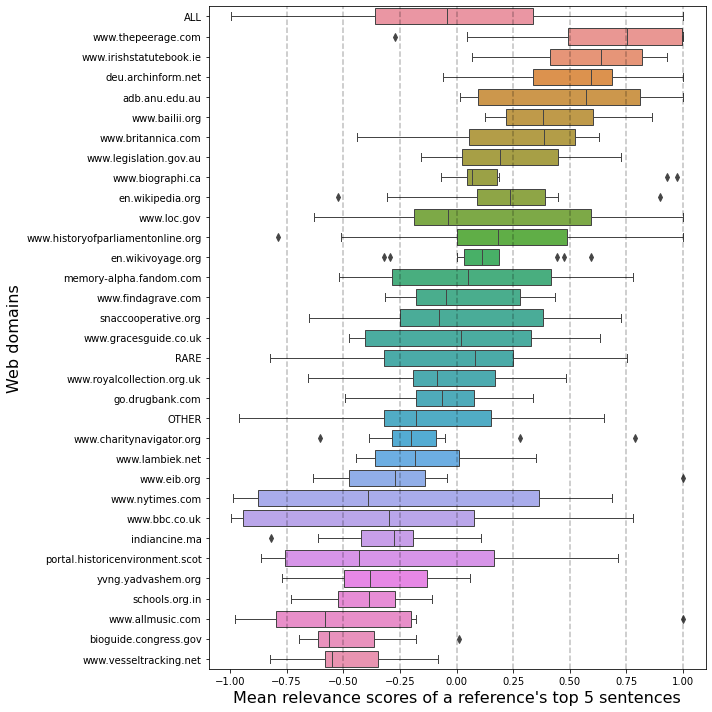

In [11]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

df = textual_entailment_df[['netloc_agg', 'nlp_sentences_all_TOP_N']].copy()

df['nlp_sentences_all_TOP_N_score_mean'] = df.nlp_sentences_all_TOP_N.apply(
    lambda x : np.mean([xx['score'] for xx in x] if len(x) > 0 else 0)
)

order = df.groupby('netloc_agg').nlp_sentences_all_TOP_N_score_mean.mean().sort_values(ascending=False).index

df2 = df.copy()
df2.netloc_agg = 'ALL'
df = pd.concat([df,df2])

sns.boxplot(
    data=df,
    x='nlp_sentences_all_TOP_N_score_mean',
    y='netloc_agg',
    order = ['ALL'] + list(order) ,
    ax=ax,
    linewidth=1
)

plt.axvline(x=1.00, c='black', ls='--', alpha=0.25)
plt.axvline(x=0.75, c='black', ls='--', alpha=0.25)
plt.axvline(x=0.50, c='black', ls='--', alpha=0.25)
plt.axvline(x=0.25, c='black', ls='--', alpha=0.25)
plt.axvline(x=0.00, c='black', ls='--', alpha=0.25)
plt.axvline(x=-0.75, c='black', ls='--', alpha=0.25)
plt.axvline(x=-0.50, c='black', ls='--', alpha=0.25)
plt.axvline(x=-0.25, c='black', ls='--', alpha=0.25)

plt.ylabel('Web domains', size=16)
plt.xlabel('Mean relevance scores of a reference\'s top 5 sentences', size=16)

plt.tight_layout()

# generate a version of this without bad netlocs
plt.savefig('../imgs/relevance_scores_per_web_domain.pdf')
plt.show()

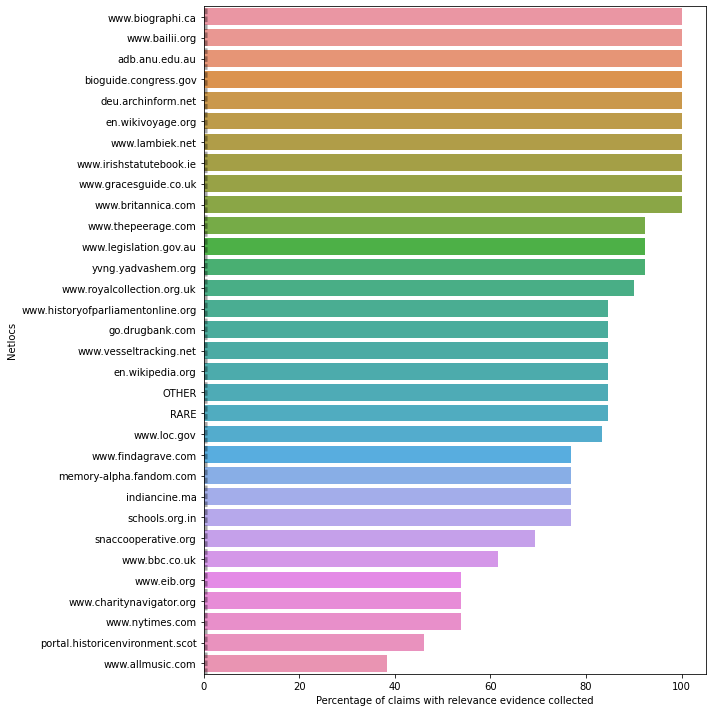

In [12]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

df = textual_entailment_df[['netloc_agg', 'nlp_sentences_all_TOP_N']].copy()

df['nlp_sentences_all_TOP_N_nonzero'] = df.nlp_sentences_all_TOP_N\
    .apply(lambda x : len([xx for xx in x if xx['score'] > SCORE_THRESHOLD]) != 0)
df['count'] = 1
df = df.groupby('netloc_agg').sum().reset_index()
df['nlp_sentences_all_TOP_N_nonzero_perc'] = 100 * df['nlp_sentences_all_TOP_N_nonzero'] / df['count']
sns.barplot(
    data=df,
    x='nlp_sentences_all_TOP_N_nonzero_perc',
    y='netloc_agg',
    order=df.sort_values('nlp_sentences_all_TOP_N_nonzero_perc', ascending=False).netloc_agg,
    orient='h',
    ax=ax
)

plt.axvline(x=0.75, c='black', ls='--', alpha=0.25)
plt.axvline(x=0.50, c='black', ls='--', alpha=0.25)
plt.axvline(x=0.25, c='black', ls='--', alpha=0.25)

plt.ylabel('Netlocs')
plt.xlabel('Percentage of claims with relevance evidence collected')

plt.tight_layout()
plt.show()